![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2F03+-+BigQuery+ML+%28BQML%29&dt=BQML+Feature+Engineering+-+Create+Model+With+Transpose.ipynb)

# BigQuery ML (BQML) - Create Model With Inline Transpose

This notebook will explore preparing data (preprocessing) for machine learning with BigQuery ML's [`CREATE MODEL` statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#create_model_syntax) as part of the inline [`TRANSFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).  This provides the benefit of also automatically including the same preprocessing during serving with the [`ML.PREDICT` function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-predict) and transportability by including the preprocessing within the [exported models](https://cloud.google.com/bigquery/docs/exporting-models) and models [directly registered to Vertex AI Model Registry](https://cloud.google.com/bigquery/docs/create_vertex). This prevents a common and complex source of [training-serving skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) in MLOps!

This notebook will cover:
- Setting up a datasource in BigQuery
- Training a Boosted Tree model with `TRANSFORM` clause
- Online Serving with Vertex AI Prediction Endpoints
- Exporting the model to GCS

**This content will accompany the blog post - TBD**

---

**BigQuery ML (BQML)**

BigQuery Machine Learning allows you to use `SQL` to constuct an ML workflow.  This is a great leap in productivity and flexibility when the data source is BigQuery and users are already familiar with `SQL`. Using just `SQL` multiple techniques can be used for model training and even include hyperparameter tuning.  Predictions can be served directly in BigQuery which also include explainability. Models can be registered to Vertex AI model registry for online predictions on Vertex AI Endpoints.

**If you know:**
```SQL
CREATE TABLE {table name}
    AS
        SELECT ...
        FROM ...
        WHERE ...
```

**Then you are ready to try:**
```SQL
CREATE MODEL {model name} 
    OPTIONS (
        MODEL_TYPE = ...
        {more options}
    )
    AS
        SELECT ...
        FROM ...
        WHERE ...
```

**You can even use:**
```SQL
CREATE OR REPLACE MODEL {model name}...
```

And

```SQL
CREATE MODEL IF NOT EXISTS {model name}...
```

**Functions for your ML Workflow**

Model Evaluation with `ML.EVALUTE`:
```SQL
SELECT *
FROM ML.EVALUTE(
    MODEL {model name},
    (
        SELECT ...
        FROM ...
        WHERE ...),
    STRUCT({optional parameters})
)
```

Prediction Using Models with `ML.PREDICT`:
```SQL
SELECT *
FROM ML.PREDICT(
    MODEL {model name},
    (
        SELECT ...
        FROM ...
        WHERE ...),
    STRUCT({optional parameters})
)
```

And [Many More](https://cloud.google.com/bigquery/docs/e2e-journey)!

---

**Feature Engineering**

Feature engineering, or [preprocessing](https://cloud.google.com/bigquery/docs/preprocess-overview), is part of making data ready for machine learning.  BigQuery ML [manual feature preprocessing](https://cloud.google.com/bigquery/docs/manual-preprocessing) functions are available to make this process simple within BigQuery.  

Each `CREATE MODEL ...` statement will do [automatic feature preprocessing](https://cloud.google.com/bigquery/docs/auto-preprocessing) by default.  It is also possible to include manual feature preprocessing in the [`CREATE MODEL` statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#create_model_syntax) as a [`TRANSFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform) where it will also become part of the model serving.  Many of these functions even accompany [exported models](https://cloud.google.com/bigquery/docs/exporting-models) and models [directly registered to Vertex AI Model Registry](https://cloud.google.com/bigquery/docs/create_vertex).

```SQL
CREATE MODEL {model name} AS
    TRANSFORM (
        ML.{function name}() OVER() as {name},
        ...
    )
    OPTIONS (
        MODEL_TYPE = ...
        {more options}
    )
    AS
        SELECT ...
        FROM ...
        WHERE ...
```
  
---

**Getting Started With BigQuery ML**
<p align="center" width="100%">
A great place to start exploring what model types are available and the functions to help create an ML workflow with each model type is this site:
    <center>
        <span style="font-size:xx-large;">
        <a href="https://cloud.google.com/bigquery/docs/e2e-journey">
            End-to-end user journey for each model
        </a>
        </span>
    </center>

Another great resourse for getting started is the "What is BigQuery ML?" starting page which include a model selection guide.
    <center>
        <span style="font-size:xx-large;">
        <a href="https://cloud.google.com/bigquery/docs/bqml-introduction">
        What is BigQuery ML?
        </a>
        </span>
    </center>
</p>

---

**Prerequisites:**

None

**Services Used:**
- BigQuery
- Vertex AI: Workbench (this notebook), Model Registry, Endpoints
- GCS

**Resources:**
- [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery/docs/bqml-introduction)
- [Overview of BQML methods and workflows](https://cloud.google.com/bigquery/docs/e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20(BQML)/BQML%20Feature%20Engineering%20-%20Create%20Model%20With%20Transpose.ipynb) and run the cells in this section.  Otherwise, skip this section.

In [475]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

Updated property [core/project].


In [473]:
try:
    import google.colab
    !pip install --upgrade google-cloud-aiplatform -q
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

**RESTART RUNTIME**

The Next cell will restart the runtime by first stopping it and then Colab will automatically restart - you may need to dismiss a popup warning letting you know about this unexpected restart.  This restart makes the installs above available to the current session.

In [474]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

---
## Environment Setup

inputs:

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [3]:
REGION = 'us-central1'
EXPERIMENT = 'feature_engineering'
SERIES = 'bqml'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'feature_engineering'
# BQ_TABLE is created below

packages:

In [70]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

from datetime import datetime
import matplotlib.pyplot as plt

clients:

In [5]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client(project = PROJECT_ID, location = 'US')
gcs = storage.Client(project = PROJECT_ID)

---
# Data Source: BigQuery

## Create BigQuery Dataset

Datasets are like folders, they hold items like tables, models, views.  Datasets are regional resources.

Create the dataset if missing:

In [7]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = 'us'
ds.labels = {'experiment': f'{EXPERIMENT}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

List BigQuery datasets in the project:

In [8]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
applied_forecasting_pipeline_bqml_arimaplus
applied_genai
applied_genai_v2
bqml
bqml_remote_model_tutorial
crossvalidation
explained_columns
feature_engineering
forecasting_8_tournament
fraud
github_api
model_deployment_monitoring_5876762107113897984


Review dataset attributes:

In [9]:
ds.dataset_id

'feature_engineering'

In [10]:
ds.project

'statmike-mlops-349915'

In [11]:
ds.full_dataset_id

'statmike-mlops-349915:feature_engineering'

In [12]:
ds.path

'/projects/statmike-mlops-349915/datasets/feature_engineering'

In [13]:
ds.location

'US'

---
## Create BigQuery Table

Familiar with the [Great British Bake Off](https://en.wikipedia.org/wiki/The_Great_British_Bake_Off)? Or maybe just familiar with intricate nature of [baking bread](https://en.wikipedia.org/wiki/Bread)?  The code below generates different bread recipes along with multiple judges ratings of the resulting bread.  These are designed to be a lot like [Ciabatta](https://en.wikipedia.org/wiki/Ciabatta).

This SQL makes heavy use of [GENERATE_ARRAY()](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#generating_arrays_of_integers) to create sequences of numbers.  The [RAND() function](https://cloud.google.com/bigquery/docs/reference/standard-sql/mathematical_functions#rand) is the primary mechanism for generating random data but it is uniform `[0, 1)` only. To generate random normal data with MEAN=0 and SD=1 the [Box-Muller Transformation](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) is implemented in SQL using two `RAND()` values as inputs.  

> Given two random uniform variable, $u_1$ and $u_2$, the following Box-Muller transformation generates two random normal(0, 1) variables:
>
> $\sqrt{-2\ln(u_1)}\sin(2\pi u_2)$ OR $\sqrt{-2\ln(u_1)}\cos(2\pi u_2)$

Expressing these as SQL:
```SQL
# ACOS(-1) = PI
SQRT(-2*LN(RAND()))*SIN(2*ACOS(-1)*RAND())

SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND())
```

**Note** When simulating data with BigQuery and using [CTEs (WITH statement)](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#with_clause) it is important to note that each CTE will be called once per reference.  That means that using the `RAND()` function could generate different data on each reference.


In [22]:
seasons = 20
rounds = 12
contestants = 20

n = seasons * rounds * contestants
BQ_TABLE = 'bread'

query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS 
WITH
    STEP_0 AS (
        SELECT
            season, round,
            CONCAT('c_', contestant) as contestant_id,
            ROW_NUMBER() OVER() recipe,
            DATE_ADD(DATE_SUB(DATE_TRUNC(DATE(EXTRACT(YEAR FROM CURRENT_DATE()), 6, 1), WEEK(FRIDAY)), INTERVAL {seasons + 1} - season YEAR), INTERVAL round - 1 WEEK) as airdate,
            season_adjuster + contestant_adjuster + round_adjuster + 2*RAND() as adjuster
        FROM (
          SELECT *
          FROM (
            SELECT season, SUM(adjuster/2) OVER(ORDER BY season) AS season_adjuster
            FROM (SELECT ROW_NUMBER() OVER() season,RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, {seasons})))
          )
          JOIN (
            SELECT CEILING(contestant/{contestants}) as season, contestant, 4*adjuster AS contestant_adjuster
            FROM (SELECT ROW_NUMBER() OVER() contestant, RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, {seasons * contestants})))
          ) USING(season)
          CROSS JOIN (
            SELECT round, SUM(adjuster/6) OVER(ORDER BY round) AS round_adjuster
            FROM (SELECT ROW_NUMBER() OVER() round, RAND() as adjuster FROM UNNEST(GENERATE_ARRAY(1, {rounds})))
          )
          ORDER BY season, round, contestant
        )
    ),
    STEP_1 AS (
        SELECT
            pos as recipe,
            * EXCEPT(pos)
        FROM (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 500+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS flourAmt)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS saltAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS yeastAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(5+1*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix1Time) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(2+3*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix1Speed) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(4+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix2Time) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(4+2*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix2Speed) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 330+20*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS water1Amt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 110+20*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS water2Amt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(40+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS waterTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 100+5*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS proveTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(35+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS restTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(20+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS bakeTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 425+15*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS bakeTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 60+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS ambTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 50+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS ambHumidity) USING(pos)
    ),
    STEP_2 AS (
        SELECT *,
            CASE 
                WHEN flourAmt-500 > 0 THEN 0.3*(flourAmt-500)
                ELSE -0.3*(flourAmt-500)
            END AS A,
            CASE 
                WHEN saltAmt-10 > 0 THEN 2*(saltAmt-10)/2
                ELSE -0.5*(saltAmt-10)/2
            END AS B,
            CASE 
                WHEN yeastAmt-10 > 0 THEN 5*(yeastAmt-10)/2
                ELSE -5*(yeastAmt-10)/2
            END AS C,
            CASE 
                WHEN mix1Time-5 > 0 THEN 2*(mix1Time-5)
                ELSE -2*(mix1Time-5)
            END AS D,
            CASE 
                WHEN mix1Speed-3.5 > 0 THEN 0.1*(mix1Speed-3.5)/1.5
                ELSE -0.1*(mix1Speed-3.5)/1.5
            END AS E,
            CASE 
                WHEN mix2Time-6 > 0 THEN (mix2Time-6)/2
                ELSE -2*(mix2Time-6)
            END AS F,
            CASE 
                WHEN mix2Speed-5 > 0 THEN 2*(mix2Speed-5)
                ELSE -2*(mix2Speed-5)/2
            END AS G,
            CASE 
                WHEN water1Amt-330 > 0 THEN (water1Amt-330)/20
                ELSE -1*(water1Amt-330)/20
            END AS H,
            CASE 
                WHEN water2Amt-110 > 0 THEN 6*(water2Amt-110)/20
                ELSE -6*(water2Amt-110)/20
            END AS I,
            CASE 
                WHEN restTime-40 > 0 THEN 3*(restTime-40)/5
                ELSE -3*(restTime-40)/5
            END AS J,
            CASE 
                WHEN bakeTime-25 > 0 THEN 6*(bakeTime-25)/5
                ELSE -6*(bakeTime-25)/5
            END AS K,
            CASE 
                WHEN bakeTemp-425 > 0 THEN 15*(bakeTemp-425)/15
                ELSE -10*(bakeTemp-425)/15
            END AS L,
            -1*((425-bakeTemp)*(bakeTime-25))/25 AS M
        FROM STEP_1
    ),
    STEP_3 AS (
        SELECT * EXCEPT(A, B, C, D, E, F, G, H, I ,J, K, L, M, adjuster),
            CASE
                WHEN 100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster < 0 THEN 0
                WHEN 100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster > 100 THEN 100
                ELSE ROUND(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)
            END AS JUDGE_A,
            CASE
                WHEN 5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)-5 < 0 THEN 0
                WHEN 5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)-5 > 100 THEN 100
                ELSE ROUND(5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+adjuster)-5)
            END AS JUDGE_B
        FROM (
            SELECT *
            FROM (SELECT * FROM STEP_0)
            JOIN (SELECT * FROM STEP_2) USING(recipe)
        )
    )
SELECT *
FROM STEP_3
ORDER BY season, round, contestant_id
"""
#print(query)

In [15]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

3.28

In [16]:
job.total_bytes_processed

0

### Check out this table in BigQuery Console:
- Click: https://console.cloud.google.com/bigquery
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and review the dataset and table

In [23]:
print(f"Direct Link To This Project In BigQuery:\nhttps://console.cloud.google.com/bigquery?project={BQ_PROJECT}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}")

Direct Link To This Project In BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!4m3!1sstatmike-mlops-349915!2sfeature_engineering!3sbread


---
## Review Data From BigQuery
Additional SQL queries could be used to review the data.  This section shows moving the table to a Pandas dataframe for local review in Python:

> **Note:** <p>This query only selects a few columns.  This means BigQuery scans less data as it does not process the other columns.  </p>

In [18]:
query = f"""
    SELECT season, JUDGE_A, JUDGE_B
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
df = bq.query(query = query).to_dataframe()

In [19]:
print(query)


    SELECT season, JUDGE_A, JUDGE_B
    FROM `statmike-mlops-349915.feature_engineering.bread`



In [20]:
df[['JUDGE_A', 'JUDGE_B']].describe()

JUDGE_A      JUDGE_B
count  4800.000000  4800.000000
mean     77.627292    67.344583
std      10.069877    13.129074
min      28.000000     3.000000
25%      72.000000    60.000000
50%      79.000000    69.000000
75%      85.000000    77.000000
max     100.000000   100.000000

It looks like Judge A is not as harsh as Judge B!

In [21]:
df.groupby('season')['JUDGE_A', 'JUDGE_B'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


JUDGE_A                                                        JUDGE_B  \
         count       mean        std   min    25%   50%    75%    max   count   
season                                                                          
1        240.0  74.370833  10.395122  36.0  69.75  76.0  81.25   94.0   240.0   
2        240.0  74.295833  10.309437  36.0  68.75  76.0  82.00   95.0   240.0   
3        240.0  75.075000   9.844109  35.0  70.00  77.0  82.00   94.0   240.0   
4        240.0  76.125000  11.049574  35.0  71.00  78.0  84.00   95.0   240.0   
5        240.0  76.570833   9.135153  45.0  71.75  77.0  84.00   96.0   240.0   
6        240.0  77.933333   9.356924  31.0  73.00  79.0  84.00   94.0   240.0   
7        240.0  76.900000  10.181121  46.0  71.00  78.0  84.00   97.0   240.0   
8        240.0  76.504167   9.729822  28.0  72.00  77.5  83.00   96.0   240.0   
9        240.0  77.954167  10.201833  48.0  72.00  80.0  85.00  100.0   240.0   
10       240.0  76.370833   9.875797  38.0  70.00  77.0  84.00   96.0   240.0   
11       240.0  77.358333  10.202384  41.0  72.00  79.5  85.00   95.0   240.0   
12       240.0  79.345833   9.038804  49.0  73.00  80.0  86.00   97.0   240.0   
13       240.0  77.950000  10.149386  35.0  72.00  79.0  86.00   97.0   240.0   
14       240.0  76.816667  10.965891  39.0  71.00  79.0  84.00   99.0   240.0   
15       240.0  78.812500  10.375495  31.0  73.00  80.5  86.00  100.0   240.0   
16       240.0  79.270833   9.734422  31.0  74.00  80.0  86.00  100.0   240.0   
17       240.0  80.325000   9.325057  50.0  75.00  82.0  87.00   98.0   240.0   
18       240.0  80.000000   9.583371  52.0  75.00  81.0  86.00   99.0   240.0   
19       240.0  79.504167   9.109744  48.0  74.00  81.0  86.00  100.0   240.0   
20       240.0  81.062500   9.327617  44.0  75.00  82.0  88.00  100.0   240.0   

                                                               
             mean        std   min    25%   50%    75%    max  
season                                                         
1       63.066667  13.509478  13.0  56.75  65.0  72.00   88.0  
2       62.970833  13.483726  13.0  55.00  65.0  73.00   90.0  
3       64.037500  12.863406  11.0  57.75  66.0  73.25   89.0  
4       65.400000  14.390780  12.0  58.00  68.0  75.25   91.0  
5       65.979167  11.917586  24.0  59.00  67.0  75.00   92.0  
6       67.725000  12.160339   7.0  61.75  70.0  76.00   89.0  
7       66.366667  13.238674  26.0  59.00  68.0  76.00   93.0  
8       65.854167  12.695648   3.0  60.00  67.0  74.00   91.0  
9       67.808333  13.264478  28.0  60.00  70.0  77.00   97.0  
10      65.704167  12.862972  16.0  57.00  67.0  75.00   91.0  
11      66.987500  13.295320  19.0  60.00  70.0  76.00   90.0  
12      69.575000  11.806078  30.0  61.00  71.0  78.25   92.0  
13      67.775000  13.223513  12.0  60.00  69.0  78.00   92.0  
14      66.345833  14.332030  16.0  59.00  69.5  76.00   96.0  
15      68.870833  13.520014   6.0  62.00  71.0  79.00   96.0  
16      69.525000  12.693004   7.0  62.75  71.0  78.00   97.0  
17      70.850000  12.111511  32.0  64.00  73.0  79.00   94.0  
18      70.379167  12.500125  33.0  64.00  72.0  79.00   96.0  
19      69.825000  11.889774  28.0  62.75  72.0  78.00   97.0  
20      71.845833  12.242203  23.0  64.00  73.0  80.00  100.0

The summary over seasons seems to indicate the judges are gradually grading easier (higher scores) or the contestants are getter better!

---
# GOAL: Predicting Judges Ratings

Each row of the BigQuery table has all the parameters of a bread recipe and the rating for the resulting bake by two judges.  The goal of the this ML project is to predict the judges rating from the recipe and understand which parameters of the recipe where most important overall ([global explainability](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-global-explain)) and for each recipe ([local explainability](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-predict)). BigQuery models include AI Explanation functions to assist with this [explainable AI](https://cloud.google.com/bigquery/docs/xai-overview).

---
# Feature Engineering With Inline TRANSFORM Clause

## Train Model

Use BigQuery ML to train a boosted tree:
- [Boosted Tree](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree) with BigQuery ML (BQML)

Feature preprocessing with the `TRANSFORM` clause:
- [TRANSFORM](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform)
- Approach:
    - The data includes columns that group the recipes into `season`, `round`.  The can be good for identify and understanding the data but for predicting future rating these might not be as helpful.  The approach here uses the `TRANSFORM` clause to omit these and instead use parts of `airdate` to more generally understand changes over time.
    - 'contestant_id' is a string the identifies the unique baker.  These are actually increment values that represent the bakers (contestants) over time.  To make this more general for use in a predictive model the `ML.LABEL_ENCODER` function is used to transform the column into a feature with integers.
    - Use a variety of [Numerical functions](https://cloud.google.com/bigquery/docs/manual-preprocessing#numerical_functions) for regularizing data with numerical expressions.

Register the model to Vertex AI Model Registry:
- `MODEL_REGISTRY` [training options](https://cloud.google.com/bigquery/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

In [24]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
RUN_NAME = f'run-{TIMESTAMP}'
BQ_MODEL = f'{SERIES}_{EXPERIMENT}_transform'

In [27]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
TRANSFORM (
    JUDGE_A,
    ML.LABEL_ENCODER(contestant_id) OVER() as contestant,
    EXTRACT(YEAR FROM airdate) as year,
    EXTRACT(ISOWEEK FROM airdate) as week,

    ML.MIN_MAX_SCALER(flourAmt) OVER() as scale_flourAmt, 
    ML.ROBUST_SCALER(saltAmt) OVER() as scale_saltAmt,
    ML.MAX_ABS_SCALER(yeastAmt) OVER() as scale_yeastAmt,
    ML.STANDARD_SCALER(water1Amt) OVER() as scale_water1Amt,
    ML.STANDARD_SCALER(water2Amt) OVER() as scale_water2Amt,

    ML.STANDARD_SCALER(waterTemp) OVER() as scale_waterTemp,
    ML.ROBUST_SCALER(bakeTemp) OVER() as scale_bakeTemp,
    ML.MIN_MAX_SCALER(ambTemp) OVER() as scale_ambTemp,
    ML.MAX_ABS_SCALER(ambHumidity) OVER() as scale_ambHumidity,

    ML.ROBUST_SCALER(mix1Time) OVER() as scale_mix1Time,
    ML.ROBUST_SCALER(mix2Time) OVER() as scale_mix2Time,
    ML.ROBUST_SCALER(mix1Speed) OVER() as scale_mix1Speed,
    ML.ROBUST_SCALER(mix2Speed) OVER() as scale_mix2Speed,
    ML.STANDARD_SCALER(proveTime) OVER() as scale_proveTime,
    ML.MAX_ABS_SCALER(restTime) OVER() as scale_restTime,
    ML.MAX_ABS_SCALER(bakeTime) OVER() as scale_bakeTime
)
OPTIONS (
        model_type = 'BOOSTED_TREE_REGRESSOR',
        booster_type = 'GBTREE',
        num_parallel_tree = 25,
        early_stop = TRUE,
        min_rel_progress = 0.01,
        tree_method = 'HIST',
        subsample = 0.85,
        #model_type = 'LINEAR_REG',        
        input_label_cols = ['JUDGE_A'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        l1_reg = 10,
        l2_reg = 10,
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{BQ_MODEL}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
print(query)


CREATE OR REPLACE MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`
TRANSFORM (
    JUDGE_A,
    ML.LABEL_ENCODER(contestant_id) OVER() as contestant,
    EXTRACT(YEAR FROM airdate) as year,
    EXTRACT(ISOWEEK FROM airdate) as week,

    ML.MIN_MAX_SCALER(flourAmt) OVER() as scale_flourAmt, 
    ML.ROBUST_SCALER(saltAmt) OVER() as scale_saltAmt,
    ML.MAX_ABS_SCALER(yeastAmt) OVER() as scale_yeastAmt,
    ML.STANDARD_SCALER(water1Amt) OVER() as scale_water1Amt,
    ML.STANDARD_SCALER(water2Amt) OVER() as scale_water2Amt,

    ML.STANDARD_SCALER(waterTemp) OVER() as scale_waterTemp,
    ML.ROBUST_SCALER(bakeTemp) OVER() as scale_bakeTemp,
    ML.MIN_MAX_SCALER(ambTemp) OVER() as scale_ambTemp,
    ML.MAX_ABS_SCALER(ambHumidity) OVER() as scale_ambHumidity,

    ML.ROBUST_SCALER(mix1Time) OVER() as scale_mix1Time,
    ML.ROBUST_SCALER(mix2Time) OVER() as scale_mix2Time,
    ML.ROBUST_SCALER(mix1Speed) OVER() as scale_mix1Speed,
    ML.ROBUST_SCALER(m

In [28]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

531.572

In [29]:
job.total_bytes_processed

27788576190

Add labels to the model in BigQuery:

In [30]:
bqml_model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
bqml_model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
bqml_model = bq.update_model(bqml_model, ['labels'])

### Feature and Training Review

Review the Model Inputs, the feature information before preprocessing, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [31]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
print(query)


    SELECT *
    FROM ML.FEATURE_INFO(MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`)



In [32]:
bq.query(query = query).to_dataframe()

input         min         max        mean      median     stddev  \
0        mix2Time    4.000000    8.000000    5.992685    6.000000   1.233598   
1       water1Amt  249.055782  403.247837  330.043420  330.044068  20.219386   
2        bakeTemp  370.462086  478.768391  425.368663  425.387130  15.143971   
3        bakeTime   20.000000   30.000000   24.938088   25.000000   2.924194   
4       proveTime   81.828180  117.068216   99.852456   99.821503   4.910245   
5       mix1Speed    2.000000    5.000000    3.491379    3.000000   0.961326   
6       water2Amt   44.858814  196.973103  109.679854  109.669713  19.945945   
7         airdate         NaN         NaN         NaN         NaN        NaN   
8       waterTemp   40.000000   50.000000   44.986416   45.000000   2.877033   
9     ambHumidity   15.513824   88.402399   49.873886   50.167885  10.177659   
10       yeastAmt    8.000000   12.000000    9.963427   10.000000   1.202827   
11       flourAmt  464.847670  539.094446  499.910467  499.901335   9.889363   
12      mix2Speed    4.000000    6.000000    4.998171    5.000000   0.710331   
13       restTime   35.000000   45.000000   40.004702   40.000000   2.932919   
14        ambTemp   27.328280  101.615204   60.073862   59.989266   9.860562   
15        saltAmt    8.000000   12.000000    9.975444   10.000000   1.242452   
16       mix1Time    2.000000    8.000000    5.015674    5.000000   1.037456   
17  contestant_id         NaN         NaN         NaN         NaN        NaN   

    category_count  null_count  dimension  
0             <NA>           0       <NA>  
1             <NA>           0       <NA>  
2             <NA>           0       <NA>  
3             <NA>           0       <NA>  
4             <NA>           0       <NA>  
5             <NA>           0       <NA>  
6             <NA>           0       <NA>  
7              240           0       <NA>  
8             <NA>           0       <NA>  
9             <NA>           0       <NA>  
10            <NA>           0       <NA>  
11            <NA>           0       <NA>  
12            <NA>           0       <NA>  
13            <NA>           0       <NA>  
14            <NA>           0       <NA>  
15            <NA>           0       <NA>  
16            <NA>           0       <NA>  
17             400           0       <NA>

Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train):

In [33]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
    ORDER BY iteration
"""
print(query)


    SELECT *
    FROM ML.TRAINING_INFO(MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`)
    ORDER BY iteration



In [34]:
history = bq.query(query = query).to_dataframe()
history

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0              0          1  54.81380   55.47980            0.3        91952
1              0          2  38.84060   39.59560            0.3           52
2              0          3  27.70890   28.48400            0.3           66
3              0          4  19.94960   20.79310            0.3           70
4              0          5  14.57790   15.48580            0.3           63
5              0          6  10.86560   11.76090            0.3          110
6              0          7   8.28401    9.38575            0.3           69
7              0          8   6.53435    7.63817            0.3           60
8              0          9   5.29837    6.39582            0.3        15670
9              0         10   4.46699    5.53626            0.3           57
10             0         11   3.88552    4.92203            0.3           52
11             0         12   3.45866    4.47603            0.3           77
12             0         13   3.14020    4.14678            0.3           58
13             0         14   2.90640    3.89820            0.3           77
14             0         15   2.71175    3.70595            0.3           54
15             0         16   2.55734    3.56235            0.3           53
16             0         17   2.41951    3.44475            0.3           58
17             0         18   2.30183    3.34597            0.3           56
18             0         19   2.19767    3.25959            0.3           62
19             0         20   2.10157    3.19111            0.3           55

Plot the loss history:

<AxesSubplot:xlabel='iteration'>

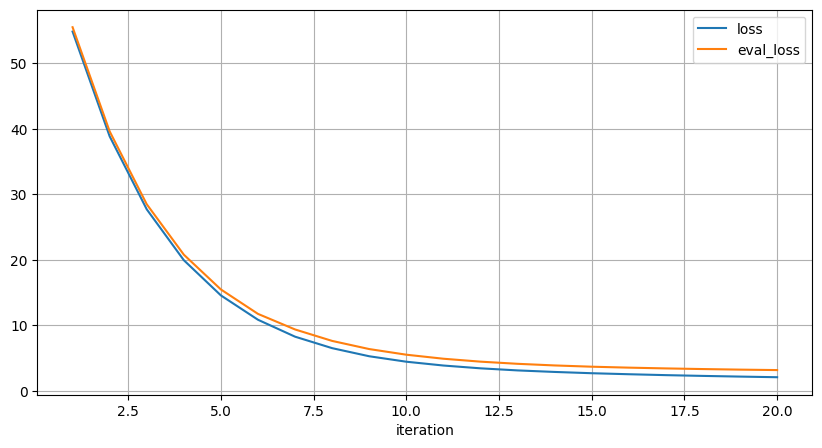

In [35]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Model Metrics Review

Review the model evaluation statistics with [ML.EVALUATE](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [36]:
query = f"""
    SELECT * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
print(query)


    SELECT * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`)



In [37]:
bq.query(query = query).to_dataframe()

mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0             2.242513            8.197958                0.001505   

   median_absolute_error  r2_score  explained_variance  
0               1.882072  0.916807            0.917342

### Feature Importance

Retrieve the [XGBoost feature importances](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_) for the model using [ML.FEATURE_IMPORTANCE](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-importance).
- importance_weight: the number of splits the feature was used in across all trees
- importance_gain: the improvement in accuracy due to splits using the feature
- importance_cover: the number of rows of data covered by splits using the feature

In [38]:
query = f"""
    SELECT *
    FROM ML.FEATURE_IMPORTANCE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
    ORDER BY importance_gain DESC
"""
print(query)


    SELECT *
    FROM ML.FEATURE_IMPORTANCE (MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`)
    ORDER BY importance_gain DESC



In [39]:
feature_importance = bq.query(query = query).to_dataframe()
feature_importance

feature  importance_weight  importance_gain  importance_cover
0      scale_bakeTemp               3077      1723.055303        648.608060
1     scale_water2Amt               2763       450.440461        489.240680
2                year               1170       312.603170        618.773504
3      scale_mix2Time                565       295.250026        715.058407
4      scale_bakeTime               1687       292.783790        437.933610
5      scale_yeastAmt               1101       254.193778        636.986376
6      scale_mix1Time               1114       189.146947        538.284560
7      scale_flourAmt               2393       154.002105        338.239866
8     scale_mix2Speed                373       134.481077        554.182306
9      scale_restTime                717        85.717913        397.451883
10      scale_saltAmt                541        75.637670        374.133087
11    scale_water1Amt               1030        43.398274        168.664078
12         contestant               1092        20.246916         78.205128
13    scale_proveTime                718        19.166594         80.030641
14      scale_ambTemp                824        17.944245         76.337379
15  scale_ambHumidity                735        15.327752         83.742857
16               week                675        14.019638         73.524444
17    scale_waterTemp                353        13.845814         54.195467
18    scale_mix1Speed                174        12.294526         63.586207

### Global Explainability - What is important to Judges?

Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [40]:
query = f"""
    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
print(query)


    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`)



In [41]:
gexplain = bq.query(query = query).to_dataframe()
gexplain

feature  attribution
0      scale_bakeTemp     6.024916
1     scale_water2Amt     2.544323
2                year     1.244881
3      scale_bakeTime     1.025809
4      scale_flourAmt     0.973105
5      scale_mix2Time     0.769810
6      scale_yeastAmt     0.755667
7      scale_mix1Time     0.597188
8     scale_mix2Speed     0.268663
9      scale_restTime     0.230816
10      scale_saltAmt     0.219477
11    scale_water1Amt     0.121160
12         contestant     0.035856
13               week     0.027385
14      scale_ambTemp     0.020811
15  scale_ambHumidity     0.013113
16    scale_proveTime     0.010081
17    scale_mix1Speed     0.007083
18    scale_waterTemp     0.005962

Plot the attribution:

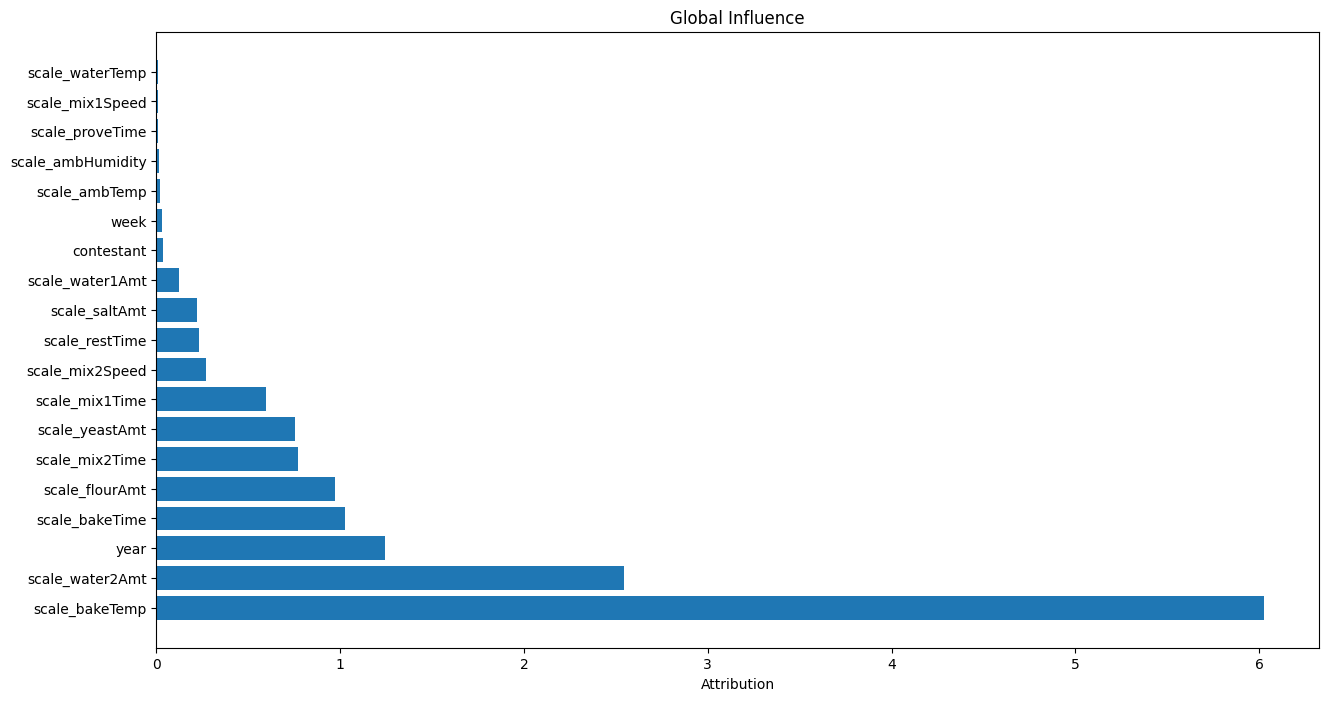

In [42]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [43]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [44]:
bq.query(query = query).to_dataframe()

Recipe  JUDGE_A  predicted_JUDGE_A     Error
0       1     75.0          73.526794  1.473206
1       2     86.0          85.937080  0.062920
2       3     87.0          86.481888  0.518112
3       4     81.0          82.495926 -1.495926
4       5     83.0          82.583466  0.416534
5       6     76.0          78.951942 -2.951942
6       7     79.0          79.647018 -0.647018
7       8     84.0          84.974556 -0.974556
8       9     77.0          82.447281 -5.447281
9      10     84.0          82.935287  1.064713

### Local Explainability - What impacted the judges rating?

Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [45]:
query = f"""
    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [46]:
explain = bq.query(query = query).to_dataframe()
explain

predicted_JUDGE_A                           top_feature_attributions  \
0          73.526794  [{'feature': 'year', 'attribution': -2.2365446...   
1          85.937080  [{'feature': 'scale_bakeTemp', 'attribution': ...   
2          86.481888  [{'feature': 'scale_bakeTemp', 'attribution': ...   
3          82.495926  [{'feature': 'scale_bakeTemp', 'attribution': ...   
4          82.583466  [{'feature': 'scale_bakeTemp', 'attribution': ...   
5          78.951942  [{'feature': 'scale_bakeTemp', 'attribution': ...   
6          79.647018  [{'feature': 'scale_bakeTemp', 'attribution': ...   
7          84.974556  [{'feature': 'scale_bakeTemp', 'attribution': ...   
8          82.447281  [{'feature': 'scale_bakeTemp', 'attribution': ...   
9          82.935287  [{'feature': 'scale_bakeTemp', 'attribution': ...   

   baseline_prediction_value  prediction_value  approximation_error  recipe  \
0                  77.436806         73.526747                  0.0       1   
1                  77.436806         85.936985                  0.0       2   
2                  77.436806         86.481768                  0.0       3   
3                  77.436806         82.495880                  0.0       4   
4                  77.436806         82.583417                  0.0       5   
5                  77.436806         78.951858                  0.0       6   
6                  77.436806         79.647017                  0.0       7   
7                  77.436806         84.974490                  0.0       8   
8                  77.436806         82.447260                  0.0       9   
9                  77.436806         82.935196                  0.0      10   

   season  round contestant_id     airdate  ...   water2Amt  waterTemp  \
0       1      1           c_1  2003-05-26  ...   98.612837         46   
1       1      1           c_2  2003-05-26  ...  111.708531         44   
2       1      1           c_3  2003-05-26  ...  101.911841         48   
3       1      1           c_4  2003-05-26  ...  131.296973         45   
4       1      1           c_5  2003-05-26  ...  100.470180         45   
5       1      1           c_6  2003-05-26  ...  130.229546         41   
6       1      1           c_7  2003-05-26  ...   85.706252         50   
7       1      1           c_8  2003-05-26  ...   99.990115         49   
8       1      1           c_9  2003-05-26  ...  101.542559         46   
9       1      1          c_10  2003-05-26  ...   94.687304         46   

    proveTime  restTime  bakeTime    bakeTemp    ambTemp  ambHumidity  \
0  105.673044        44        28  435.393493  51.279961    61.443331   
1   93.831810        42        21  423.411066  75.692056    35.545136   
2  104.969749        40        20  426.042110  59.630283    63.139995   
3  100.003988        39        28  425.303916  63.791167    69.601895   
4   96.943759        38        25  433.129239  57.452172    56.456663   
5  102.368168        41        21  428.770877  62.391203    66.493702   
6  106.748456        42        24  429.830463  62.704889    50.332733   
7  105.191873        35        25  423.358189  67.455814    47.565266   
8   94.640184        42        25  428.768843  66.431606    32.277536   
9   96.571240        39        25  424.924214  43.868904    58.789972   

   JUDGE_A  JUDGE_B  
0     75.0     63.0  
1     86.0     78.0  
2     87.0     80.0  
3     81.0     72.0  
4     83.0     75.0  
5     76.0     65.0  
6     79.0     69.0  
7     84.0     75.0  
8     77.0     66.0  
9     84.0     76.0  

[10 rows x 28 columns]

Create a plot of feature attributions for a single prediction:

In [47]:
recipe = 1
explanation = explain.iloc[recipe-1]['top_feature_attributions']

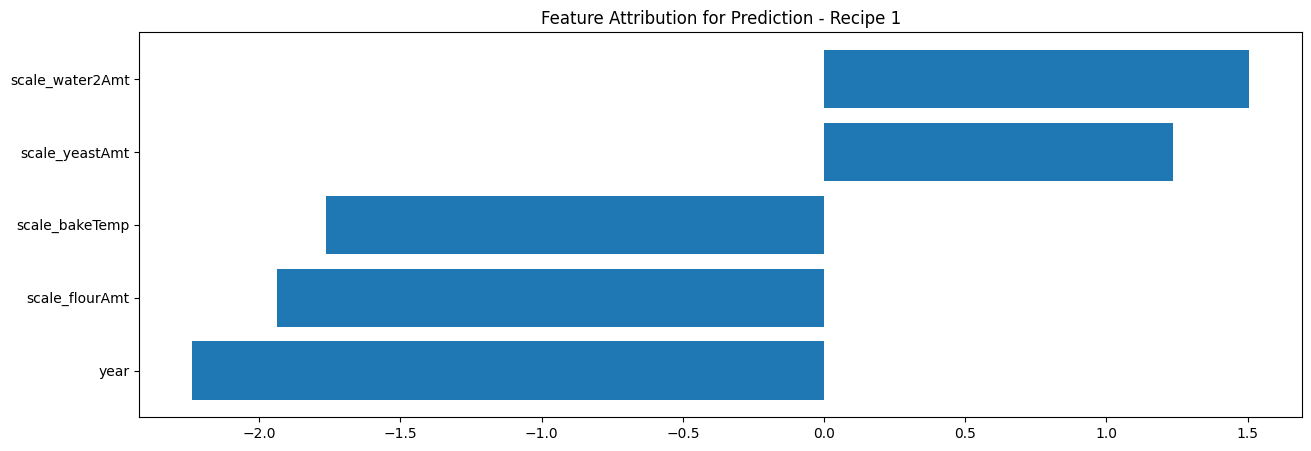

In [48]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title(f'Feature Attribution for Prediction - Recipe {recipe}')
plt.show()

### Check out this model in the BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [49]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfeature_engineering!3sbqml_feature_engineering_transform


### Check out this model in the Vertex AI Console:
- Make sure project selected is the one from this notebook
- Make sure the region is `europe-west4` (default when BQ is `EU` multiregion)

In [50]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_bqml_feature_engineering_transform?project=statmike-mlops-349915


---
## Serving

**Notes on Serving With Manual Feature Engineering**

When this model was trained it also registered to Vertex AI Model Registry.  With the inline `TRANSFORM` clause the resulting model is also directly servable even though it is actually 2 models, a preprocessing model that represents the `TRANSFORM` clause, and a model that serves responses from the inputs shaped by the preprocessing.  When deployed the models and pipelined together on the same endpoint.  As long as the `TRANSFORM` statement used [supported SQL functions](https://cloud.google.com/bigquery/docs/exporting-models#export-transform-functions) this will work.

### Vertex AI Model Registry - Get Models

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model unsing Vetex AI.

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [53]:
vertex_model = aiplatform.Model(model_name = f'bqml_{BQ_MODEL}')
vertex_model.resource_name

'projects/1026793852137/locations/us-central1/models/bqml_bqml_feature_engineering_transform'

In [54]:
aiplatform.ModelEvaluation(
    evaluation_name = vertex_model.get_model_evaluation().resource_name
).to_dict()

{'name': 'projects/1026793852137/locations/us-central1/models/bqml_bqml_feature_engineering_transform@1/evaluations/5578997075363758080',
 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/regression_metrics_1.0.0.yaml',
 'metrics': {'meanAbsoluteError': 2.2425125,
  'rootMeanSquaredError': 2.8632076,
  'rSquared': 0.9168072,
  'rootMeanSquaredLogError': 0.03879608},
 'createTime': '2023-07-05T12:05:51.543719Z'}

In [56]:
# note: this is blank since the model is in two parts which are managed in a single container at deployment, see export below:
vertex_model.uri 

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [57]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{EXPERIMENT}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else: endpoint_transform = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}_transform")[0]

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944/operations/7776347870650695680
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/6287935475437010944')
Endpoint Created: bqml_feature_engineering


In [58]:
endpoint.display_name

'bqml_feature_engineering'

In [59]:
endpoint.traffic_split

{}

In [60]:
deployed_models = endpoint.list_models()
deployed_models

[]

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

Reference:
- [aiplatform.Endpoint.deploy()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)

In [61]:
endpoint.deploy(
    model = vertex_model,
    deployed_model_display_name = vertex_model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/1026793852137/locations/us-central1/models/bqml_bqml_feature_engineering_transform to Endpoint : projects/1026793852137/locations/us-central1/endpoints/6287935475437010944
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944/operations/5776749636098195456
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


In [62]:
endpoint.list_models()

[id: "7768764332795494400"
 model: "projects/1026793852137/locations/us-central1/models/bqml_bqml_feature_engineering_transform"
 display_name: "bqml_bqml_feature_engineering_transform"
 create_time {
   seconds: 1688559727
   nanos: 579630000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-2"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 explanation_spec {
   parameters {
     sampled_shapley_attribution {
       path_count: 5
     }
   }
   metadata {
     inputs {
       key: "airdate"
       value {
       }
     }
     inputs {
       key: "ambHumidity"
       value {
       }
     }
     inputs {
       key: "ambTemp"
       value {
       }
     }
     inputs {
       key: "bakeTemp"
       value {
       }
     }
     inputs {
       key: "bakeTime"
       value {
       }
     }
     inputs {
       key: "contestant_id"
       value {
       }
     }
     inputs {
       key: "flourAmt"
       value {
       }
     }
     inputs {
       

---
## Prediction

### Retrieve Records For Prediction
The first 10 recipes.

**Notes:**
- Exclude columns not used in the model.  While BigQuery ML.PREDICT can handle parsing these out, the model hosted on Vertex AI Prediction Endpoints has an expected input signature of just the features used in the model.
- The feature `airdate` is a date formated feature.  In the model this is stored as a string and needs to be converted for Vertex AI Prediction.
- To check the expected features and format of features you can also export the model and used the TensorFlow saved model CLI to review the signature.  This is demonstrated in the `Model Exports` section below.

In [136]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT(JUDGE_A, JUDGE_B, season, round, recipe) # exclude columns not used in model
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE Recipe <= 10
        ORDER BY Recipe
    """
).to_dataframe()
pred['airdate'] = pred['airdate'].astype(str)

In [137]:
pred

contestant_id     airdate    flourAmt  saltAmt  yeastAmt  mix1Time  \
0           c_1  2003-05-26  484.289865        9        10         5   
1           c_2  2003-05-26  501.259590        9        10         3   
2           c_3  2003-05-26  495.194450        8        11         5   
3           c_4  2003-05-26  498.689824        9        12         4   
4           c_5  2003-05-26  502.184684       10         9         4   
5           c_6  2003-05-26  500.544560       12        11         4   
6           c_7  2003-05-26  508.734730       11         9         4   
7           c_8  2003-05-26  495.788757        9        12         3   
8           c_9  2003-05-26  516.618334       12        11         3   
9          c_10  2003-05-26  482.890706        8         8         6   

   mix1Speed  mix2Time  mix2Speed   water1Amt   water2Amt  waterTemp  \
0          3         5          5  311.663494   98.612837         46   
1          4         5          4  315.472473  111.708531         44   
2          4         8          4  324.477611  101.911841         48   
3          4         8          5  321.759002  131.296973         45   
4          3         5          5  297.358523  100.470180         45   
5          2         5          6  288.291749  130.229546         41   
6          4         6          5  341.572993   85.706252         50   
7          2         7          5  335.026274   99.990115         49   
8          4         8          6  310.179809  101.542559         46   
9          2         5          5  325.829584   94.687304         46   

    proveTime  restTime  bakeTime    bakeTemp    ambTemp  ambHumidity  
0  105.673044        44        28  435.393493  51.279961    61.443331  
1   93.831810        42        21  423.411066  75.692056    35.545136  
2  104.969749        40        20  426.042110  59.630283    63.139995  
3  100.003988        39        28  425.303916  63.791167    69.601895  
4   96.943759        38        25  433.129239  57.452172    56.456663  
5  102.368168        41        21  428.770877  62.391203    66.493702  
6  106.748456        42        24  429.830463  62.704889    50.332733  
7  105.191873        35        25  423.358189  67.455814    47.565266  
8   94.640184        42        25  428.768843  66.431606    32.277536  
9   96.571240        39        25  424.924214  43.868904    58.789972

Shape as instances: dictionaries of key:value pairs for only features used in model

In [138]:
newobs = pred.to_dict(orient='records')

In [139]:
newobs[0]

{'contestant_id': 'c_1',
 'airdate': '2003-05-26',
 'flourAmt': 484.28986452656386,
 'saltAmt': 9,
 'yeastAmt': 10,
 'mix1Time': 5,
 'mix1Speed': 3,
 'mix2Time': 5,
 'mix2Speed': 5,
 'water1Amt': 311.66349401065276,
 'water2Amt': 98.61283742264706,
 'waterTemp': 46,
 'proveTime': 105.67304373851782,
 'restTime': 44,
 'bakeTime': 28,
 'bakeTemp': 435.39349280229476,
 'ambTemp': 51.27996072412186,
 'ambHumidity': 61.44333141984406}

### Get Predictions: Python Client

Reference:
- [aiplatform.Endpoint.predict()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_predict)

In [140]:
prediction = endpoint.predict(instances = newobs[0:])
prediction.predictions

[73.52679443359375,
 85.93708038330078,
 86.48188781738281,
 82.49593353271484,
 82.58346557617188,
 78.95195007324219,
 79.64701843261719,
 84.97455596923828,
 82.44728088378906,
 82.93528747558594]

#### Compare to BigQuery ML.PREDICT Results:

In [141]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
bq.query(query = query).to_dataframe()

Recipe  JUDGE_A  predicted_JUDGE_A     Error
0       1     75.0          73.526794  1.473206
1       2     86.0          85.937080  0.062920
2       3     87.0          86.481888  0.518112
3       4     81.0          82.495926 -1.495926
4       5     83.0          82.583466  0.416534
5       6     76.0          78.951942 -2.951942
6       7     79.0          79.647018 -0.647018
7       8     84.0          84.974556 -0.974556
8       9     77.0          82.447281 -5.447281
9      10     84.0          82.935287  1.064713

---
# Model Exports



### Manually export models from BigQuery

The models trained in BQML can be exported from BigQuery to GCS:

References:
- [Exporting Models](https://cloud.google.com/bigquery/docs/exporting-models)
- [`EXPORT MODEL` statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-export-model)


In [142]:
BUCKET = f'{PROJECT_ID}-{REGION}-bqml-exports'

In [143]:
if not gcs.lookup_bucket(BUCKET):
    bucketDef = gcs.bucket(BUCKET)
    bucketDef = gcs.create_bucket(bucketDef, project=PROJECT_ID, location=REGION)
    print(f'Created Bucket: {gcs.lookup_bucket(BUCKET).name}')
else:
    bucketDef = gcs.bucket(BUCKET)
    print(f'Bucket already exist: {bucketDef.name}')

Bucket already exist: statmike-mlops-349915-us-central1-bqml-exports


In [144]:
print(f'Review the storage bucket in the console here:\nhttps://console.cloud.google.com/storage/browser/{BUCKET};tab=objects&project={PROJECT_ID}')

Review the storage bucket in the console here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915-us-central1-bqml-exports;tab=objects&project=statmike-mlops-349915


In [145]:
query = f"""
    EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
        OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/model');
"""
print(query)


    EXPORT MODEL `statmike-mlops-349915.feature_engineering.bqml_feature_engineering_transform`
        OPTIONS (URI = 'gs://statmike-mlops-349915-us-central1-bqml-exports/bqml/model');



In [146]:
export = bq.query(query = query)
export.result()
(export.ended - export.started).total_seconds()

38.912

In [147]:
list(bucketDef.list_blobs(prefix = f'{SERIES}'))

[<Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/, 1688563304427607>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/, 1688563304743435>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/assets/model_metadata.json, 1688564779912946>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/explanation_metadata.json, 1688564779500036>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/main.py, 1688564779767363>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/model.bst, 1688564779320162>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/transform/, 1688563305221371>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/transform/assets/, 1688563306204677>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/transform/assets/dict.txt, 1688564776859452>,
 <Blob: statmike-mlops-349915-us-central1-bqml-exports, bqml/model/transform/fingerprint.pb, 16

**Observe**

The model with a `TRANSFORM` clause has a `/model` folder as well as a `/model/transform` that each contain a model save file.  

In [148]:
print(f'Review the models in the storage bucket with the console here:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES};tab=objects&project={PROJECT_ID}')

Review the models in the storage bucket with the console here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915-us-central1-bqml-exports/bqml;tab=objects&project=statmike-mlops-349915


**Review the Models Serving Signature**

To understand the features and formats expected by the model as inputs use the [TensorFlow SavedModel CLI](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface) to review the serving signature.

In [154]:
!saved_model_cli show --dir gs://{BUCKET}/{SERIES}/model/transform --signature_def serving_default --tag_set serve

2023-07-05 13:52:39.533343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 13:52:42.923733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-07-05 13:52:42.923909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

---
# Remove Resources
It is important to remove the resources created for this demonstration to prevent ongoing cost associated with storage (GCS, BigQuery) and Vertex AI Endpoints.  The code below removes all the resources created by this notebook.
- gcs bucket delete (contains model exports)
- endpoints (need to undeploy any models in use)
- bq_model (delete these first, before the dataset.  This also removes them from Vertex AI)
- bq_dataset

In [155]:
# delete gcs bucket
bucketDef.delete(force = True)

In [156]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
endpoint.delete(force = True)

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944/operations/8407274030947631104


INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944/operations/8407274030947631104


Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


Deleting Endpoint : projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


Delete Endpoint  backing LRO: projects/1026793852137/locations/us-central1/operations/1919838767720431616


INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/1026793852137/locations/us-central1/operations/1919838767720431616


Endpoint deleted. . Resource name: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/1026793852137/locations/us-central1/endpoints/6287935475437010944


In [157]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
#bq.delete_model(bqml_model)

In [158]:
# remove the BQ dataset created for this notebook
#bq.delete_dataset(ds, delete_contents = True)